## Step 2. Extraction of features & modelling

Here I'll convert each subimage (each segment/superpixel) from different satellite images to long vector of features, with a help of (magic!) [Keras](https://keras.io/) library and model called [ResNet50](https://keras.io/applications/#resnet50), pretrained on ImageNet dataset. 

Note, directory __"./datasets/positive/"__ should contain examples of segments with amber mining, and 
directory __"./datasets/negative/"__ should contain segments without such patterns.

It's an example of ["transfer learning"](https://en.wikipedia.org/wiki/Transfer_learning): ResNet50 is trained on images from categories such as "dog", "car", "tree", but I'll use quite different satellite images with "natural" objects such as trees or agriculture fields, as an input. 

Anyway, ResNet50 neural network allow me to obtain the values from its penultimate layer  as features for classifier. It's possible because ResNet, even pretrained with quite different pictures, has learn to find a representation of *any* image as a high-dimencional vector with the same length (2048 in this case). 

There are many ways to improve this step (i.e to train ResNet50 for more specific categories/images such as OSM labels and corresponding satellite images). But why bother if you could achieve result which is good enough, without additional complications? 

To reproduce code below with tolerable time of execution, you have to install CUDA drivers for your GPU (if you have one).  OR just run next cell and after that jump to cell with such code (unzip file features_backup.csv.zip, first):
```python 
df = pd.read_csv("features_backup.csv")
```
and load precalculated features. Also, you should do this if you don't have an images in "negative" and "positive" directories.


NOTE: This is short, educational version for "how to create a model" notebook. More detailed version, with explanation of my process of "visual debugging" of the model, one could [find here](visually_debug_model.ipynb)

In [37]:
import tensorflow as tf
import numpy as np

import pandas as pd

import time
from os import listdir, environ
from os.path import isfile, join

# to allocate only one GPU for this notebook (I have two on board)
# environ["CUDA_VISIBLE_DEVICES"]="0" 

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score
#from sklearn.externals import joblib
import joblib

from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt


# adds
import PIL
#print(PIL.__version__)

### ResNet50 model

In [38]:
positive_img_path =  "./datasets/positive/"  # where to find positive examples (images with amber extraction footprints ) 
negative_img_path =  "./datasets/negative/"  # where to find negative examples 


In [39]:
# list of positive and negative filenames
positive_files = [join(positive_img_path, f) for f in listdir(positive_img_path) if isfile(join(positive_img_path, f))] # list of image names with positive examples
negative_files = [join(negative_img_path, f) for f in listdir(negative_img_path) if isfile(join(negative_img_path, f))] # list of image names with negative examples

#resnet = ResNet50(weights='imagenet', include_top=False) # load ResNet50
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

### Feature extraction

In [40]:
###
# Old Code
###
# def extract_features(img_paths, batch_size=64):
#     """ This function extracts image features for each image in img_paths using ResNet50 penultimate layer.
#         Returned features is a numpy array with shape (len(img_paths), 2048).
#     """
#     global resnet
#     n = len(img_paths) # num of images in img_paths
#     img_array = np.zeros((n, 224, 224, 3))
    
#     for i, path in enumerate(img_paths):
#         img = image.load_img(path, target_size=(224, 224))  # load and scale each image to 224x224 size
#         img = image.img_to_array(img)
#         img = preprocess_input(img)
#         img_array[i] = img
    
#     X = resnet.predict(img_array, batch_size=batch_size, verbose=1)
#     X = X.reshape((n, 2048))
#     return X

# # features for our two types of labels
# positives_ = extract_features(positive_files)
# negatives_ = extract_features(negative_files)

###
# New code
###

# Initialize the ResNet50 model
#resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_paths, batch_size=64):
    """ This function extracts image features for each image in img_paths using ResNet50 penultimate layer.
        Returned features is a numpy array with shape (len(img_paths), 2048).
    """
    global resnet
    n = len(img_paths)  # num of images in img_paths
    img_array = np.zeros((n, 224, 224, 3))
    
    for i, path in enumerate(img_paths):
        img = image.load_img(path, target_size=(224, 224))  # load and scale each image to 224x224 size
        img = image.img_to_array(img)
        img = preprocess_input(img)
        img_array[i] = img
    
    X = resnet.predict(img_array, batch_size=batch_size, verbose=1)
    print(f"Shape of X before reshaping: {X.shape}")  # Debugging statement
    #X = X.reshape((n, 2048))
    return X

# Example usage
#positive_files = ["path/to/image1.jpg", "path/to/image2.jpg"]  # Replace with actual paths
#negative_files = ["path/to/image3.jpg", "path/to/image4.jpg"]  # Replace with actual paths

# features for our two types of labels
positives_ = extract_features(positive_files)
negatives_ = extract_features(negative_files)

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step
Shape of X before reshaping: (250, 2048)
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Shape of X before reshaping: (900, 2048)


In [41]:
# Create dataframe from two types of features, for positive images(with amber mining footprints) and 
# negative(without mining) 

###
# Old code
# ###
# def create_df(feature_vectors, label, img_paths):
#     """ create panda df. Each row in df consists of features, label and path to corresponding image """
#     feat_cols = [ 'feature'+str(i) for i in range(feature_vectors.shape[1]) ] # column names for elements of feature vector
#     df = pd.DataFrame(feature_vectors,columns=feat_cols)
#     df['label'] = label # add column with labels
#     df['path'] = img_paths # add column with img paths
#     return df

# df1 = create_df(positives_, "positive", positive_files)
# df2 = create_df(negatives_, "negative", negative_files)
# df = df1.append(df2)
# print('Size of the dataframe: {}'.format(df.shape))

# in case you want to save features for later use, uncomment line below
# df.to_csv("features_backup.csv",  index = False) 


###
# New code
###


# Create dataframe from two types of features, for positive images(with amber mining footprints) and 
# negative(without mining) 

def create_df(feature_vectors, label, img_paths):
    """ create panda df. Each row in df consists of features, label and path to corresponding image """
    feat_cols = [ 'feature'+str(i) for i in range(feature_vectors.shape[1]) ] # column names for elements of feature vector
    df = pd.DataFrame(feature_vectors, columns=feat_cols)
    df['label'] = label # add column with labels
    df['path'] = img_paths # add column with img paths
    return df

df1 = create_df(positives_, "positive", positive_files)
df2 = create_df(negatives_, "negative", negative_files)
df = pd.concat([df1, df2], ignore_index=True)  # Use pd.concat instead of append
print('Size of the dataframe: {}'.format(df.shape))

# in case you want to save features for later use, uncomment line below
df.to_csv("features_backup.csv",  index = False)


Size of the dataframe: (1150, 2050)


In [42]:
### IGNORE this cell if you successfully run all cells above.

### START HERE if you don't want to calculate features from images: instead, get it from backup
df = pd.read_csv("features_backup.csv")

### Now it's time for the modelling!
Here we'll try couple of different models for our labeled features, extracted from images

In [43]:
X = df.iloc[:,0:2048].values  # numeric feature values for each image
Y = df.iloc[:, 2048].values   # labels for each image
tiles = df["path"].values     # path to image files 

# split each list to test and train parts 
X_train, X_test, Y_train, Y_test, tiles_train, tiles_test = train_test_split(X, Y, tiles, test_size = 0.3, 
                                                                             random_state = 43)
###
# Old code
###

# Just print all evaluation scores from one place
# def evaluate(Y_test, Y_pred):
#     accuracy = accuracy_score(Y_test, Y_pred)
#     print("\nModel Performance")
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
#     print(confusion_matrix(Y_test, Y_pred))
#     print("\nprecision:")
#     print(precision_score(Y_test, Y_pred, pos_label = "positive"))
#     print("\nrecall:")
#     print(recall_score(Y_test, Y_pred, pos_label = "positive"))
#     print("\nf1:")
#     print(f1_score(Y_test, Y_pred, pos_label = "positive") ) 
#     return accuracy

###
# New code
###

# def evaluate(y_true, y_pred):
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_true, y_pred))
#     print("\nPrecision:")
#     print(precision_score(y_true, y_pred, pos_label=1))  # Use 1 as the positive label
#     print("\nRecall:")
#     print(recall_score(y_true, y_pred, pos_label=1))  # Use 1 as the positive label

def evaluate(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a heatmap for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0-negative', '1-positive'], yticklabels=['0-negative', '1-positive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print precision and recall
    print("\nPrecision:")
    print(precision_score(y_true, y_pred, pos_label=1))  # Use 1 as the positive label
    print("\nRecall:")
    print(recall_score(y_true, y_pred, pos_label=1))  # Use 1 as the positive label



### XGBoost

I've tried a couple of classifiers here: SVM, RandomForests, XGBoost.

Best results were from XGBoost. For current (example) features you could get:

|Type of classifier|F1 score|recall|
|------------------|--------|------|
|RandomForests|0.7|0.56|
|XGBoost (vanilla)|0.82|0.74|
|XGBoost (optimised)*|0.876|0.80|


`*` See below parameters for optimised version

For production model I've got F1 score = 0.917 wih recall = 0.88 (with help of [visual debugging, see here](visually_debug_model.ipynb) ). Not a record, but quite enough for my purposes.

Below is optimised parameter set for XGBoost

In [44]:
###
# Old code
###
# todo https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/


# clf = XGBClassifier( learning_rate =0.01,
#                      n_estimators=5000,
#                      max_depth=4,
#                      min_child_weight=6,
#                      gamma=0,
#                      subsample=0.8,
#                      colsample_bytree=0.8,
#                      reg_alpha=0.005,
#                      objective= 'binary:logistic',
#                      nthread=7,
#                      scale_pos_weight=1,seed=27
#                    )


# clf.fit(X_train, Y_train)


# to save a model, uncomment this
# joblib.dump(clf, 'versions/xgb_model.pkl')

# you can load actual production model from this file, uncomment line below:
# clf = joblib.load( 'versions/xgb_model_v003.pkl')

###
# New code
###


# Assuming Y_train and Y_test are your target variables
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

clf = XGBClassifier(
    learning_rate=0.01,
    n_estimators=5000,
    max_depth=4,
    min_child_weight=6,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.005,
    objective='binary:logistic',
    nthread=7,
    scale_pos_weight=1,
    seed=27
)

clf.fit(X_train, Y_train_encoded)

###
# Old code
###
# to save a model, uncomment this
#joblib.dump(clf, 'versions/xgb_model.pkl')

# Save the model using XGBoost's Booster class (modern way)
booster = clf.get_booster()
booster.save_model('versions/xgb_model.json')


# you can load actual production model from this file, uncomment line below:
# clf = joblib.load('versions/xgb_model_v003.pkl')


### Model evaluation

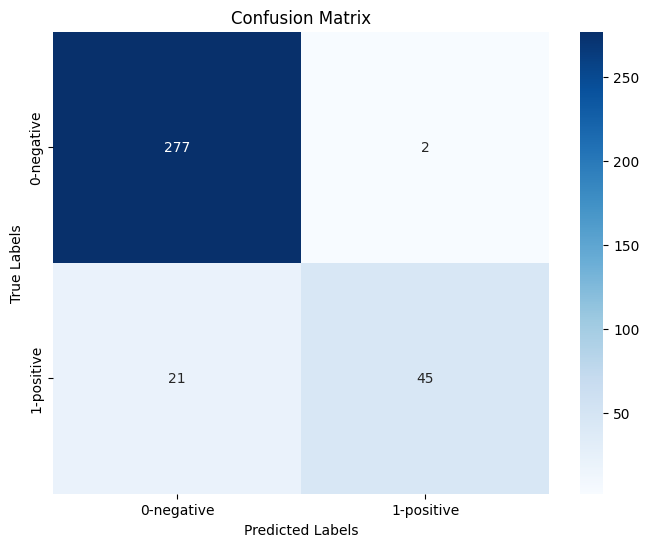


Precision:
0.9574468085106383

Recall:
0.6818181818181818


In [45]:
###
# Old code
###

#Y_pred = clf.predict(X_test) 
#evaluate(Y_test, Y_pred)

###
# New code
###

# Assuming Y_test is your target variable for testing
label_encoder = LabelEncoder()
Y_test_encoded = label_encoder.fit_transform(Y_test)

# Predict using the classifier
Y_pred = clf.predict(X_test)

# Evaluate using the encoded Y_test
evaluate(Y_test_encoded, Y_pred)

In [ ]:
#  Precision: 0.9574468085106383

# Definition: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It answers the question: "Of all the instances that were predicted as positive, how many were actually positive?"
# Interpretation: A precision of approximately 0.96 means that 96% of the instances predicted as positive are actually positive. This indicates a low false positive rate.
# Recall: 0.6818181818181818

# Definition: Recall (or Sensitivity) is the ratio of correctly predicted positive observations to all the observations in the actual class. It answers the question: "Of all the instances that are actually positive, how many were correctly predicted as positive?"
# Interpretation: A recall of approximately 0.68 means that 68% of the actual positive instances were correctly identified by the model. This indicates a moderate false negative rate.

### Next step: actual search 
Now, we have trained model and could search for satellite images with amber mining. [See Step 3](step3.ipynb)